In [36]:
import pandas as pd
import numpy as np
from skimage import io, transform
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import os
import os.path
import matplotlib.pyplot as plt
import cv2
plt.ion()  

In [37]:
def showimg(url):
    """Show image """
    plt.imshow(io.imread(url),cmap='gray', vmin=0, vmax=255)
    plt.pause(0.001)  # pause a bit so that plots are updated

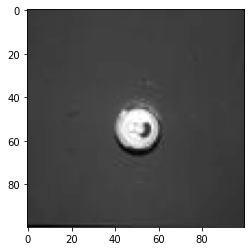

In [38]:
showimg('imgs2/imgxy/25.jpg')

In [39]:
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized
to_one_hot([1,2,3,0])

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

In [40]:
def int21hot(n,num):
    ret=np.zeros(num)
    ret[n-1]=1
    return ret
int21hot(2,5)

array([0., 1., 0., 0., 0.])

In [41]:
def getFirstInt(content): #get the first integer number of a string, used for obtaining hand number from image names
    intchars=[]
    intstarted=False
    intended=False
    for i in range(len(content)):
        if content[i].isdigit():
            intchars.append(content[i])
            intstarted=True
        if intstarted:
            if not content[i].isdigit():
                intended=True
        if intstarted and intended:
            break
    return int(''.join(intchars))
getFirstInt('21.jpg')

21

In [42]:
#dataframe storing labels 
xdf=pd.read_csv('extradatayolo.csv')
xdf=xdf.drop('Unnamed: 0',axis=1)
maxctg=max(xdf.loc[:,'category'])
leng=xdf.shape[0]
xdf

,category,centx,centy,w,h
0,1,25.5,58.5,51,51
1,1,48.0,49.5,56,53
2,1,46.0,69.5,56,53
3,1,31.0,44.5,54,53
4,1,47.5,38.5,77,75
...,...,...,...,...,...
118,4,49.5,25.0,19,18
119,4,42.5,59.5,23,23
120,4,42.0,78.0,24,28
121,6,30.0,62.0,22,22


In [43]:
labelcols=[0,1,2,3,4]
catlabels=xdf.iloc[0,labelcols[0]]
bblabels=np.array(list(xdf.iloc[0,labelcols[1:]]))
catlabels=int21hot(catlabels,6)*20
np.concatenate([catlabels,bblabels])

array([20. ,  0. ,  0. ,  0. ,  0. ,  0. , 25.5, 58.5, 51. , 51. ])

In [44]:
from torch.utils.data import Dataset, DataLoader
failcount=0
labelcols=[0,1,2,3,4]
conticols=[]
catew=100
class WareDataset(Dataset):
    def __init__(self, main_dir, transform=None):
        self.main_dir=main_dir
        self.subdirs=os.listdir(self.main_dir)
        self.transform=transform
        self.labeldf=pd.DataFrame(columns=['name','label','path'])
        self.count=0
        
        imgnames=os.listdir(main_dir)
        for name in range(leng):
            mypathxy=os.path.join(main_dir,'imgxy',str(name)+'.jpg')
            mypathxz=os.path.join(main_dir,'imgxz',str(name)+'.jpg')
            catlabels=xdf.iloc[name,labelcols[0]]
            bblabels=np.array(list(xdf.iloc[name,labelcols[1:]]))
            catlabels=int21hot(catlabels,6)*catew
            #put all information for each sample in a dic,except images
            #at this stage images only have their dirs saved in order to save memory
            #images will be retrieved when _getitem() is called
            appdic={'name':name,'label':np.concatenate([catlabels,bblabels]),'path':[mypathxy,mypathxz]}
            self.labeldf=self.labeldf.append(appdic,ignore_index=True)
            self.count+=1
                
    def __len__(self):
        return self.count
    
    def setLen(self,leng):
        self.count=leng
    
    def __getitem__(self,idx):
        global failcount
        img_paths = self.labeldf.loc[idx,'path']
        imagexy = io.imread(img_paths[0])
        imagexz = io.imread(img_paths[1])
        ima,imb=imagexy.shape
        label = self.labeldf.loc[idx, 'label']
        #put 2 images into 1 tensor
        newimg=np.array([imagexy,imagexz])
        return torch.tensor(newimg).double(),torch.tensor(label)
            
    def getitems(self,idxs): #return multiple pairs of image tensors and label tensors in a list of tuples
        ret=[]
        for idx in idxs:
            ret.append(self[idx])
        return ret
        
    def getlabeldf(self):
        return self.labeldf

In [45]:
#This function creates train, validation and test dataloaders from a dataset
gltrvalset=None
def get_data_loader(batch_size,dataset,ttratio):
    failcount=0
    gdset=dataset
    gdlabeldf=gdset.getlabeldf()
    names=gdlabeldf.loc[:,'name']
    leng,wid=xdf.shape
    testnum=int(round((1-ttratio)*leng))
    testdexs=[]
    trvaldexs=list(range(leng)) #for train and validation
    while len(testdexs)<testnum:
        mydex=np.random.randint(leng)
        if not mydex in testdexs:
            testdexs.append(mydex)
    for n in testdexs:
        trvaldexs.remove(n)
    
    trvalset=gdset.getitems(trvaldexs)
    global gltrvalset
    gltrvalset=trvalset
    testset=gdset.getitems(testdexs)
    print('length of training set:',len(trvalset))
    print('length of testset:',len(testset))
    split = int(len(trvaldexs) * 0.8)
    trvalredexs=list(range(0,len(trvaldexs))) #reset train&validate set indices
    np.random.seed(1000)
    np.random.shuffle(trvalredexs)
    traindexs,valdexs=trvalredexs[:split],trvalredexs[split:]
    train_sampler = SubsetRandomSampler(traindexs)
    train_loader = torch.utils.data.DataLoader(trvalset, batch_size=batch_size,
                                               num_workers=0, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(valdexs)
    val_loader = torch.utils.data.DataLoader(trvalset, batch_size=batch_size,
                                              num_workers=0, sampler=val_sampler)
    test_sampler = SubsetRandomSampler(list(range(0,len(testdexs)))) #reset test_loader indices
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=0, sampler=test_sampler)
    return train_loader, val_loader, test_loader

In [46]:
def rmse(predictions, targets):
    return np.sqrt(((predictions.detach().numpy() - targets.detach().numpy()) ** 2).mean())

In [47]:
numctg=6
bbsfc1size=5
class CNNnet(nn.Module):
    def __init__(self):
        super(CNNnet, self).__init__()
        self.name = "cnn"
        self.conv1 = nn.Conv2d(1, 5, 5,padding=2) #1*100*100->5*100*100
        self.pool = nn.MaxPool2d(2, 2) #5*100*100->5*50*50
        self.conv2 = nn.Conv2d(5, 10, 5,padding=2) #5*50*50->10*50*50
        self.fc0 = nn.Linear(10*25*25, hiddensize)
        self.fcbb = nn.Linear(hiddensize, 4)
        self.ctgfc1 = nn.Linear(10*25*25*2+4, hiddensize)
        self.fcctg = nn.Linear(hiddensize, numctg)

    def forward(self, x):
        ximgxy=x[:,0,:,:][:,None]
        ximgxz=x[:,1,:,:][:,None]
        #print('ximgxy:',ximgxy)
        x0=self.conv1(ximgxy)
        #print('conv1 ximg:',x)
        x0 = self.pool(F.relu(x0))
        x0 = self.pool(F.relu(self.conv2(x0))) 
        x0 = x0.view(-1, 10*25*25)
        xbbs=F.relu(self.fc0(x0))
        xbbs=self.fcbb(xbbs).squeeze(1)
        x2=self.conv1(ximgxz)
        #print('conv1 ximg:',x)
        x2 = self.pool(F.relu(x2))
        x2 = self.pool(F.relu(self.conv2(x2))) 
        x2 = x2.view(-1, 10*25*25)
        #print('x.view(-1, 10*22*22).shape:',x.shape)
        xctg=torch.cat((x0,x2,xbbs),1)
        xctg=F.relu(self.ctgfc1(xctg))
        xctg=self.fcctg(xctg).squeeze(1)
        return torch.cat((xctg,xbbs),1)

In [48]:
t1=torch.tensor([1,2,3])
torch.cat([t1,t1,t1])

tensor([1, 2, 3, 1, 2, 3, 1, 2, 3])

In [49]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def evaluate(net, loader, criterion):
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr=rmse(labels,outputs)
        total_err += corr
        total_loss += loss.item()
        total_epoch += len(labels) #actually total number of labels
    err = float(total_err) / total_epoch #(total number of network outputs not meeting labels)/(total number of labels)
    loss = float(total_loss) / (i + 1)
    return err, loss

def plot_training_curve(path):
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [50]:
import time
def train_net(net,train_loader,val_loader, batch_size=64, learning_rate=0.01, num_epochs=30,retain_graph=False):
    ########################################################################
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    epochcount=0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        #print('current epoch:',epochcount)
        epochcount+=1
        i=0
        for inputs,labels in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.double())
            loss.backward() #dloss/dx
            optimizer.step()
            # Calculate the statistics
            corr=rmse(labels,outputs)
            total_train_err += corr
            total_train_loss += loss.item()
            total_epoch += len(labels)
            i+=1
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
        #if i==0
        #print(net.state_dict())
        
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [58]:
hiddensize=128
cnn = CNNnet()
cnn=cnn.double()
wdset=WareDataset('imgs2')

C:\Users\Czr19\AppData\Local\Temp/ipykernel_13304/2433152794.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.labeldf=self.labeldf.append(appdic,ignore_index=True)
C:\Users\Czr19\AppData\Local\Temp/ipykernel_13304/2433152794.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.labeldf=self.labeldf.append(appdic,ignore_index=True)
C:\Users\Czr19\AppData\Local\Temp/ipykernel_13304/2433152794.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.labeldf=self.labeldf.append(appdic,ignore_index=True)
C:\Users\Czr19\AppData\Local\Temp/ipykernel_13304/2433152794.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.labeld

In [59]:
bsize=20 #batch size
lrate=0.000005 #learning rate
numep=50 #num of epochs
train_loader, val_loader, test_loader = get_data_loader(bsize,wdset,0.9)
train_net(cnn,train_loader, val_loader,batch_size=bsize, learning_rate=lrate, num_epochs=numep)

length of training set: 111
length of testset: 12
Epoch 1: Train err: 2.173792662034351, Train loss: 1230.7608322648755 |Validation err: 2.898867347605638, Validation loss: 1111.8250159868512
Epoch 2: Train err: 1.7802234251800342, Train loss: 819.856579845767 |Validation err: 2.49252286553556, Validation loss: 821.6492785177597
Epoch 3: Train err: 1.641434688559299, Train loss: 696.6751268372019 |Validation err: 2.4458167858802544, Validation loss: 793.0667567550679
Epoch 4: Train err: 1.5659758967187642, Train loss: 633.5476841729668 |Validation err: 2.608009872513618, Validation loss: 899.866038635689
Epoch 5: Train err: 1.4185313266095163, Train loss: 520.2419063223211 |Validation err: 2.461428429044406, Validation loss: 807.1160288678983
Epoch 6: Train err: 1.349613926116515, Train loss: 471.0595937125195 |Validation err: 2.2014480245042525, Validation loss: 642.5799714948878
Epoch 7: Train err: 1.2486465133718008, Train loss: 403.81367266889987 |Validation err: 2.5232316293846053

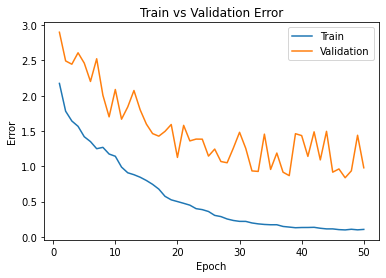

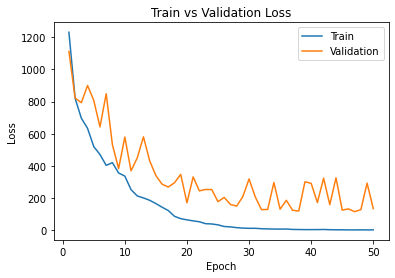

In [60]:
model_path = get_model_name("cnn", batch_size=bsize, learning_rate=lrate, epoch=numep-1)
plot_training_curve(model_path)

In [61]:
for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        labels=labels.detach().numpy()
        outputs = cnn(inputs).detach().numpy()
        labbbs=labels[:,6:]
        predbbs=outputs[:,6:]
        labctg=np.argmax(labels[:,0:6],axis=1)
        predctg=np.argmax(outputs[:,0:6],axis=1)
        print("labels:     ",labctg)
        print("predictions:",predctg)

labels:      [4 3 3 3 2 1 3 3 2 1 4 0]
predictions: [4 3 3 3 2 1 3 3 2 1 4 0]
